In [1]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.utils import shuffle
from tqdm.auto import tqdm, trange
from google.colab import files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [30]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 100
# Количество классов новостей
nb_classes = 2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
fake = pd.read_csv('/content/drive/MyDrive/Datasets/Fake.csv', delimiter = ',') 
true = pd.read_csv('/content/drive/MyDrive/Datasets/True.csv', delimiter = ',')

In [7]:
fake['target'] = 0 
true['target'] = 1 

df = pd.DataFrame() 
df = true.append(fake)

In [8]:
# Shuffle the data 
df = shuffle(df).reset_index(drop=True) 
df.head()

,title,text,subject,date,target
0,How North Korea's latest ICBM test stacks up,SEOUL (Reuters) - North Korea said on Wednesda...,worldnews,"November 29, 2017",1
1,"Trump calls for waterboarding, other methods i...",WASHINGTON (Reuters) - U.S. Republican White H...,politicsNews,"February 7, 2016",1
2,"Poll: Clinton Leads Trump By 10 Points, Obama...",While the media will have you believe Donald T...,News,"September 11, 2016",0
3,GOP Official Just Quit Trump’s Bogus Voter Fr...,"So far, forty-four states are resisting the Tr...",News,"July 4, 2017",0
4,OKLAHOMA LAWMAKER BLASTED FOR SAYING: “Shouldn...,Oklahoma State Rep. John Bennett made a commen...,politics,"Aug 20, 2017",0


In [9]:
df['text']=df['text']+" "+df['title']

In [10]:
df.drop(['title','subject','date'],axis=1,inplace=True) 
df.head()

,text,target
0,SEOUL (Reuters) - North Korea said on Wednesda...,1
1,WASHINGTON (Reuters) - U.S. Republican White H...,1
2,While the media will have you believe Donald T...,0
3,"So far, forty-four states are resisting the Tr...",0
4,Oklahoma State Rep. John Bennett made a commen...,0


In [11]:
import re
import string

def clean_text(text): 
  stopwords_english = stopwords.words('english') 
  text= re.sub('\[[^]]*\]', '', text) 
  # remove stock market tickers like $GE
  text = re.sub(r'\$\w*', '', text) 
  #removal of html tags 
  review =re.sub(r'<.*?>',' ',text) 
  # remove old style retweet text "RT" 
  text = re.sub(r'^RT[\s]+', '', text) 
  # remove hyperlinks 
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) 
  # remove hashtags 
  # only removing the hash # sign from the word 
  text = re.sub(r'#', '', text) 
  text = re.sub("["
                 u"\U0001F600-\U0001F64F" # removal of emoticons 
                 u"\U0001F300-\U0001F5FF" # symbols & pictographs 
                 u"\U0001F680-\U0001F6FF" # transport & map symbols 
                 u"\U0001F1E0-\U0001F1FF" # flags (iOS) 
                 u"\U00002702-\U000027B0" 
                 u"\U000024C2-\U0001F251" 
                 "]+",' ',text) 
  text = re.sub('[^a-zA-Z]',' ',text)
  
  text = text.lower() 
  text_clean = text 
  return text_clean

In [12]:
df['clean_text']=df['text'].apply(lambda x: clean_text(x))
df.head()

,text,target,clean_text
0,SEOUL (Reuters) - North Korea said on Wednesda...,1,seoul reuters north korea said on wednesda...
1,WASHINGTON (Reuters) - U.S. Republican White H...,1,washington reuters u s republican white h...
2,While the media will have you believe Donald T...,0,while the media will have you believe donald t...
3,"So far, forty-four states are resisting the Tr...",0,so far forty four states are resisting the tr...
4,Oklahoma State Rep. John Bennett made a commen...,0,oklahoma state rep john bennett made a commen...


Selecting data for training

Highlighting the correct answers

In [39]:
X = df['clean_text']
y = utils.to_categorical(df['target'], nb_classes)

In [40]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Creating a Keras Tokenizer

In [42]:
tokenizer = Tokenizer(num_words=num_words)

We train the tokenizer on the news

In [43]:
tokenizer.fit_on_texts(X_train)

Viewing the tokenizer dictionary

In [44]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 's': 7,
 'that': 8,
 'on': 9,
 'for': 10,
 'is': 11,
 'trump': 12,
 'said': 13,
 'he': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'by': 19,
 'his': 20,
 'has': 21,
 'be': 22,
 'not': 23,
 'have': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'an': 30,
 'they': 31,
 'u': 32,
 'we': 33,
 'i': 34,
 'but': 35,
 'president': 36,
 'would': 37,
 'will': 38,
 'about': 39,
 't': 40,
 'their': 41,
 'had': 42,
 'you': 43,
 'been': 44,
 'people': 45,
 'were': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'one': 51,
 'she': 52,
 'her': 53,
 'state': 54,
 'if': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'new': 59,
 'when': 60,
 'up': 61,
 'its': 62,
 'there': 63,
 'also': 64,
 'obama': 65,
 'reuters': 66,
 'over': 67,
 'clinton': 68,
 'house': 69,
 'no': 70,
 'government': 71,
 'donald': 72,
 'so': 73,
 'states': 74,
 'our': 75,
 'can': 76,
 'republican': 77,
 'him': 78,
 'year': 79,
 'just': 80,
 't

Converting news to a numeric representation

In [45]:
sequences = tokenizer.texts_to_sequences(X_train)

Limiting the length of news

In [50]:
X_train = pad_sequences(sequences, maxlen=max_news_len)

In [51]:
X_train[:5]

array([[  15,   61,    6, 6145,   51,   37,  173, 1267,   37,   22,    4,
         411,   23,  106,   11,   14,   23,  383,   14,  844,    2,   24,
        5006,    8,   14,  423,  282,    1, 1209,  476,    2, 3676,    1,
         298,  476, 1385,  278,  423, 3865,  232,   55, 1267, 7251,    2,
           4,  549,   14, 3058,  531,   15,    1,  167,   14, 2850,   15,
          11,   73, 3021,    9,    8,   15,    7,  710,  732,  251,  592,
          16,    4, 7740, 2204,  296, 1635,    9,  514,  183,  376,  305,
         488,  265,  226,  175, 1413, 1513,   25, 6613,  189,  251, 4982,
        3865, 4960,   88, 3629,    2, 1444, 1267, 8903,    8,  344,  158,
         476],
       [  27,  981,   80,    2, 1757,  115, 1099,  381,    7,   23,  418,
         137,   45,  173,   39,  359,  381,    7,  406,  359, 1823,    5,
         144, 1145,   90, 1047,   26,  780,   60,   31,   28, 2138,   41,
          86,   27,    1,  442, 4557,  262,   58,    1, 1913, 6092,   31,
          28,  113,  62

**Convolutional Neural Network**

In [52]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

In [53]:
model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [54]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32128     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 392,636
Trainable params: 392,636
Non-trainable params: 0
________________________________________________

We create a callback to save the neural network at each epoch if the quality of work on the test dataset has improved. The network is saved to the file best_model.h5

In [55]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [56]:
history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=8,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/8
237/237 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9108
Epoch 1: val_accuracy improved from -inf to 0.97714, saving model to best_model_cnn.h5
237/237 [==============================] - 27s 108ms/step - loss: 0.1967 - accuracy: 0.9108 - val_loss: 0.0592 - val_accuracy: 0.9771
Epoch 2/8
237/237 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9924
Epoch 2: val_accuracy improved from 0.97714 to 0.98040, saving model to best_model_cnn.h5
237/237 [==============================] - 26s 108ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 0.0531 - val_accuracy: 0.9804
Epoch 3/8
237/237 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9991
Epoch 3: val_accuracy did not improve from 0.98040
237/237 [==============================] - 25s 105ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0622 - val_accuracy: 0.9804
Epoch 4/8
237/237 [==============================] - ETA: 0s - loss: 8.6941e-04 - acc

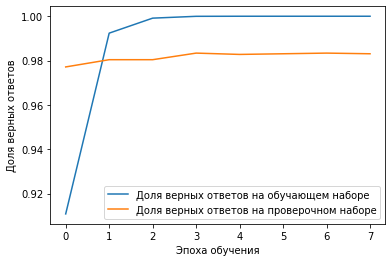

In [57]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Test dataset**

In [58]:
test_sequences = tokenizer.texts_to_sequences(X_test)

In [59]:
X_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [60]:
model_cnn.load_weights(model_cnn_save_path)

In [62]:
model_cnn.evaluate(X_test, y_test, verbose=1)

351/351 [==============================] - 4s 10ms/step - loss: 0.0598 - accuracy: 0.9850


[0.05982929840683937, 0.985033392906189]